# Preprocess

In [ ]:
%load_ext autoreload
%autoreload 2

## Env

CUDA toolkit

In [16]:
#!sudo apt-get update
# Checking the GPU configuration, hardware level; drive level; CUDA level
!nvidia-smi
import tensorflow as tf # type: ignore
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#!lscpu | grep NUMA


Thu Nov 21 12:25:07 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.02              Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070        On  |   00000000:21:00.0  On |                  N/A |
| 30%   28C    P8             11W /  200W |   10490MiB /  12282MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [17]:
import tensorflow as tf # type: ignore
# GPU test
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else:
    print('Found GPU at: {}'.format(device_name))
    print('Tensorflow version {}'.format(tf.__version__))

Found GPU at: /device:GPU:0
Tensorflow version 2.13.1


2024-11-21 12:25:07.658753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-21 12:25:07.659246: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-21 12:25:07.659579: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-21 12:25:07.660178: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:21:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-21 12:25:07.660228: I tensorflow/core/co

## Install Lib

In [ ]:
#!pip install -r requirements.txt

## Import Lib

In [20]:
import numpy as np # type: ignore
import os
import tensorflow as tf # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.image as mpimg # type: ignore
import random
import re
import time
import pytz # type: ignore
import importlib

# custom functions
import MoviLSTMnet_toolkit

from datetime import datetime
from skimage.metrics import mean_squared_error # type: ignore
from matplotlib.colors import ListedColormap # type: ignore


from skimage.transform import resize # type: ignore
from sklearn.model_selection import train_test_split# type: ignore
from imageio import imread # type: ignore

from official.projects.movinet.modeling import movinet # type: ignore
from official.projects.movinet.modeling import movinet_model # type: ignore
from cv2 import line # type: ignore


from PIL import Image # type: ignore
from matplotlib.colors import Normalize # type: ignore
from matplotlib.ticker import MaxNLocator, FuncFormatter # type: ignore
from matplotlib.font_manager import FontProperties # type: ignore


from tensorflow.keras.utils import plot_model # type: ignore


seed, for repilicate the study

In [21]:
random.seed(33)
np.random.seed(33)
tf.random.set_seed(33)

## Function

### Generator
review: Range is used for generate a sequence of numbers
enumerate  is typically used in for loops when you need the index along with the element.

In [22]:
def ResizeImage(image, target_height, target_width):
    """
    Resize the image to the target dimensions.

    Parameters:
        image (numpy.ndarray): The input image to be resized.
        target_height (int): The target height for the resized image.
        target_width (int): The target width for the resized image.

    Returns:
        numpy.ndarray: The resized image.
    """
    # Resize the image to the target dimensions with anti-aliasing and 'reflect' mode
    image_resized = resize(image, (target_height, target_width), 
                           anti_aliasing=True, 
                           mode='reflect')  # 'reflect' mode reflects the last few pixels at the border
    
    return image_resized


def normalizeImage(image):
    """
    Normalize the image by scaling pixel values to the range [0, 1].

    Parameters:
        image (numpy.ndarray): The input image to be normalized.

    Returns:
        numpy.ndarray: The normalized image.
    """
    # Apply normalization by dividing pixel values by 255
    return image / 255.0


def preprocessImage(image, img_height, img_width):
    """
    Preprocess the image by resizing and normalizing it.

    Parameters:
        image (numpy.ndarray): The input image to be preprocessed.
        img_height (int): The target height for the resized image.
        img_width (int): The target width for the resized image.

    Returns:
        numpy.ndarray: The preprocessed image.
    """
    # Resize the image and then normalize it
    return normalizeImage(ResizeImage(image, img_height, img_width))


def make3dFilter(x):
    """
    Create a 3D filter tuple with the same value repeated three times.

    Parameters:
        x (any): The value to be repeated in the tuple.

    Returns:
        tuple: A tuple with the value repeated three times.
    """
    return tuple([x] * 3)


def make2dFilter(x):
    """
    Create a 2D filter tuple with the same value repeated two times.

    Parameters:
        x (any): The value to be repeated in the tuple.

    Returns:
        tuple: A tuple with the value repeated two times.
    """
    return tuple([x] * 2)


def getBatchData(input_folder_list, output_folder_list, batch_idx, batch_size, imgs_tensor):
    """
    Prepare a batch of data for training/testing.

    Parameters:
        source_path (str): Path to the data directory.
        shuffled_folder_list (list): List of shuffled folder names.
        batch_idx (int): Index of the current batch.
        batch_size (int): Number of samples in each batch.
        imgs_tensor (tuple): Contains dimensions and indices for image processing.
        img_idxs (list): A list of image indices to be read.
        idx (int): the number of image indices 
        folder_idx (int): the number of a folder (a folder is a sequence)
    Returns:
        Tuple of (batch_data, batch_labels)  for a certain batch (eg:id = 2)
    """
    
    [num_imgs,img_height,img_width] = [len(imgs_tensor[0]), imgs_tensor[1], imgs_tensor[2]]
    img_idxs = imgs_tensor[0]  # Assuming this is a list of image indices to be read; IMAGE INDICES, very important

    data_shape = (batch_size, num_imgs, img_height, img_width, 3) # 3 is the number of RGB channels
    batch_data = np.zeros(data_shape, dtype=np.float32) 
    batch_labels = np.zeros(data_shape, dtype=np.float32) 

    # Retrieve the folder names for the current batch from the CSV
    
    for folder_idx in range(batch_size): # a folder is a sequence
        # Load input images
        base_input_idx = folder_idx + (batch_idx * batch_size) 
        input_imgs_path = input_folder_list[base_input_idx]
        label_imgs_path = output_folder_list[base_input_idx]
        
        input_imgs = os.listdir(input_imgs_path)
        label_imgs = os.listdir(label_imgs_path)

        for idx, item in enumerate(img_idxs):

            input_img_path = os.path.join(input_imgs_path, input_imgs[item])
            label_img_path = os.path.join(label_imgs_path, label_imgs[item])
            
            img = imread(input_img_path).astype(np.float32)
            label_img = imread(label_img_path).astype(np.float32)
            for c in range(3): # For RGB channels
                batch_data[folder_idx, idx, :, :, c] = preprocessImage(img[:,:,c], img_height, img_width)
                batch_labels[folder_idx, idx, :, :, c] = preprocessImage(label_img[:,:,c], img_height, img_width)
        # Load label images (assuming similar structure and processing as input images)   
    return batch_data, batch_labels


def generator(source_path, input_folder_list, output_folder_list, batch_size, imgs_tensor):
    """
    for adjust batch size

    Parameters:
      source_path (str): Path to the data directory.
      input_folder_list (list): List of shuffled input folder names.
      output_folder_list (list): List of shuffled outputput folder names.   
      batch_size (int): Number of samples in each batch.
      imgs_tensor (tuple): Contains dimensions and indices for image processing.

    
    Returns:
      check get batch data
    """
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        num_batches = int(len(input_folder_list)/batch_size)
        for batch_idx in range(num_batches): #  Iterate over the number of batches
            yield getBatchData(input_folder_list, output_folder_list, batch_idx, batch_size, imgs_tensor)        
        # write the code for the remaining data points which are left after full batches
        # checking if any remaining batches are there or not
        if len(input_folder_list)%batch_size != 0:
            # updated the batch size and yield
            batch_size = len(input_folder_list)%batch_size # take the remainder
            yield getBatchData(input_folder_list, output_folder_list, batch_idx, batch_size, imgs_tensor)
            
def getImgTensor(n_frames):
    """
    Generate a tensor for image data with specified number of frames.

    Parameters:
        n_frames (int): The number of frames to generate indices for.

    Returns:
        list: A list containing the frame indices and the dimensions of the image tensor.
    """
    
    # Generate evenly spaced indices from 0 to 100, rounded to the nearest integer
    img_idx = np.round(np.linspace(0, 100, n_frames)).astype(int)
    
    # Return the list containing the frame indices and the dimensions of the image tensor
    return [img_idx, 60, 80, 3]  # The dimensions are [number of frames, height, width, channels]

### Postprocessing

In [23]:
# Function to plot model history from a DataFrame
def plotModelHistoryFromFile(history_df, fig_initial_value=1, save_fig=False, file_name=None, fig_vars=None):
    """
    Plots the training and validation history of a model from a DataFrame.

    Parameters:
        history_df (pandas.DataFrame): DataFrame containing the training history.
        fig_initial_value (int): Initial value for the epoch range. Default is 1.
        save_fig (bool): Whether to save the figure to a file. Default is False.
        file_name (str): Name of the file to save the figure. Default is None.
        fig_vars (list of tuples): List of tuples specifying the variables to plot and their titles.
                                   Each tuple should be in the form (train_var, val_var, title). Default is None.

    Returns:
        None
    """
    # Create subplots
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))
    fontsize_label = 12
    
    # Extract keys from DataFrame columns
    keys = history_df.columns
    
    # Default plot variables if not provided
    if fig_vars is None:
        fig_vars = [
            ('loss', 'val_loss', "Train loss vs Validation loss"),
            ('root_mean_squared_error', 'val_root_mean_squared_error', "Train RMSE vs Validation RMSE") # previously, it used MSE
        ]
    
    # Number of epochs (assuming epochs start from fig_initial_value)
    epochs = range(fig_initial_value, fig_initial_value + len(history_df['loss']))
    
    # Iterate over the plot settings and plot each subplot
    for i, (train_var, val_var, title) in enumerate(fig_vars):
        if train_var in keys and val_var in keys:
            # Plot training and validation variables
            ax[i].semilogy(epochs, history_df[train_var], label=train_var)
            ax[i].semilogy(epochs, history_df[val_var], label=val_var)
            ax[i].legend(fontsize=fontsize_label)
            ax[i].set_title(title, fontsize=fontsize_label)
            
            # Additional settings for the subplot
            for spine in ax[i].spines.values():
                spine.set_linewidth(2)
            ax[i].tick_params(direction='in', which='both')
            ax[i].grid(which='both', linestyle='--', linewidth=0.5)
            ax[i].set_xlabel('Epoch', fontsize=fontsize_label)
            ax[i].set_ylabel(ax[i].get_ylabel(), fontsize=fontsize_label)
        else:
            print(f"Warning: {train_var} or {val_var} not found in DataFrame columns.")

    # Adjust layout to ensure subplots do not overlap
    fig.tight_layout()
    plt.show()
    
    # Save the figure if required
    if save_fig:
        if file_name is None:
            # Generate a default file name with a timestamp if none is provided
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            file_name = f'res_{timestamp}.png'
        fig.savefig(file_name, dpi=300)
        print(f"Figure saved as {file_name}")

    # Print max MSE values if available
    if 'loss' in keys and 'val_loss' in keys:
        print("Max. Training MSE:", max(history_df['loss']))
        print("Max. Validation MSE:", max(history_df['val_loss']))
    else:
        print("Warning: 'loss' or 'val_loss' not found in DataFrame columns.")
    
    # Uncomment the following lines to print all history keys and values
    # print("Columns:", keys)
    # for key in keys:
    #     print(f"{key}:", history_df[key].values)

# Function to find the closest scalar value for a given color
def find_closest_scalar(color, df):
    """
    Find the closest scalar value for a given RGB color from a DataFrame.

    Parameters:
        color (tuple or list): The RGB color to find the closest match for. Should be in the form (R, G, B).
        df (pandas.DataFrame): DataFrame containing 'Red', 'Green', 'Blue' columns and corresponding 'Scalar' values.

    Returns:
        float: The scalar value corresponding to the closest RGB color in the DataFrame.
    """
        
    distances = np.linalg.norm(df[['Red', 'Green', 'Blue']].values - np.array(color[:3]), axis=1)
    closest_index = np.argmin(distances)
    return df.loc[closest_index, 'Scalar']

# Encapsulated function
def find_and_plot_closest_scalar(data, scalar_color_map, frame_index=0, roi_size=20, data_batch_size=0, show_image=True):
    """
    Find the closest scalar value for a color in the center ROI of the given frame, and plot the frame.

    Parameters:
        data (numpy.ndarray): The data array containing frames.
        scalar_color_map (pandas.DataFrame): DataFrame containing 'Red', 'Green', 'Blue' columns and corresponding 'Scalar' values.
        frame_index (int): The index of the frame to analyze. Default is 0.
        roi_size (int): The size of the Region of Interest (ROI) centered on the frame. Default is 20.
        data_batch_size (int): The batch size index to select data from. Default is 0.
        show_image (bool): Whether to show the image of the frame. Default is True.


    Returns:
        float: Calculated true value of heat flux.
    """

    # Set the center point (x, y)
    center_x, center_y = data.shape[3] // 2, data.shape[2] // 2

    # Validate ROI size
    if roi_size <= 0 or roi_size > min(center_x, center_y):
        raise ValueError("ROI size must be a positive integer and less than or equal to the half size of the frame dimensions.")

    # Define the ROI (Region of Interest)
    half_size = roi_size // 2
    roi = data[data_batch_size, frame_index, center_y - half_size:center_y + half_size + 1, center_x - half_size:center_x + half_size + 1, :3]

    # Calculate the average color in the ROI
    average_color = np.mean(roi, axis=(0, 1))

    # Normalize the average color if necessary
    if average_color.max() > 1:
        average_color = average_color / 255.0

    # Append alpha value 255 to the average color if necessary
    if len(average_color) == 3:
        average_color = np.append(average_color, 255)

    # Find the closest scalar value for the center color
    closest_scalar = find_closest_scalar(average_color, scalar_color_map)

    print(f"The closest scalar value for the center color {average_color} is {closest_scalar}")

    # Plot the frame
    if show_image:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(data[data_batch_size, frame_index])
        plt.title(f"Frame {frame_index}")
        plt.axis('off')
        plt.show()

    return closest_scalar


def cal_true_value(heatflux_type, **kwargs):
    """
    Calculate the true value of heat flux based on the specified type.

    Parameters:
        heatflux_type (str): Type of heat flux ('constant' or 'sin').
        kwargs: Additional parameters based on the heatflux_type.

            For 'constant':
                groundtruth_heatflux (list): List of ground truth heat flux values.
                closest_filename_index (int): Index for selecting the ground truth value.
            For 'sin':
                time_point (float): Time point for sine function calculation.
                A (float): Amplitude for sine function.
            

                
    Returns:
        float: Calculated true value of heat flux.
    
    """
    if heatflux_type == 'constant':
        groundtruth_heatflux = kwargs.get('groundtruth_heatflux')
        closest_filename_index = kwargs.get('closest_filename_index', 0)

        if groundtruth_heatflux is None:
            raise ValueError("groundtruth_heatflux must be provided when heatflux_type is 'constant'.")

        # If the heat flux is constant, return the ground truth value directly
        true_value = groundtruth_heatflux[closest_filename_index]

    elif heatflux_type == 'sin':
        time_point = kwargs.get('time_point')
        A = kwargs.get('A')

        if time_point is None or A is None:
            raise ValueError("For 'sin' type, both 'time_point' and 'A' must be provided.")

        # Calculate the true value using the sine function
        true_value = A * np.sin(((np.pi * time_point + 1) / 30) - np.pi / 2) + A

    else:
        raise ValueError("Invalid heatflux_type. Must be 'constant' or 'sin'.")

    return true_value

def calculate_errors_single_frame(prediction, ground_truth, batch_index, frame_index):
    """
    Calculate error metrics for a single frame in a batch of predictions and ground truth data.

    Parameters:
        prediction (numpy.ndarray): The predicted data array.
        ground_truth (numpy.ndarray): The ground truth data array.
        batch_index (int): The index of the batch to analyze.
        frame_index (int): The index of the frame within the batch to analyze.

    Returns:
        tuple: A tuple containing the Mean Squared Error (MSE), Mean Absolute Error (MAE), and Mean Error Percentage (MEP).
    """
    
    # Extract the predicted and ground truth frames for the specified batch and frame indices
    predicted_frame = prediction[batch_index, frame_index]
    ground_truth_frame = ground_truth[batch_index, frame_index]
    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(ground_truth_frame, predicted_frame)
    
    # Calculate Mean Absolute Error (MAE)
    mae = np.mean(np.abs(ground_truth_frame - predicted_frame))

    # Calculate the ratio of the mean predicted value to the mean ground truth value
    ratio = np.mean(predicted_frame) / np.mean(ground_truth_frame)
    
    # Calculate Mean Error Percentage (MEP)
    me_p = ratio - 1    

    return mse, mae, me_p

## Parameters

### Environment parameters

In [24]:
# Define global variable for font properties
font_properties = FontProperties(fname='/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf', size=20) # type: ignore


#curr_dt_time = datetime.datetime.now()

project_folder = '/home/linux/IHCPs'
material_name = 'ptrh'
heatflux_type = 'constant'
dataset_name = f'/dataset_{material_name}_{heatflux_type}'

dataset_source_path = project_folder + dataset_name

# Define the path to the dataset_info.csv file
dataset_info_path = os.path.join(dataset_source_path, 'dataset_info.csv')

# Load the dataset information, more details in dataset_info.csv
MoviLSTMnet_toolkit.csv_generator(dataset_source_path)

# Check if the file exists before reading it
if os.path.exists(dataset_info_path):
    dataset_info = pd.read_csv(dataset_info_path)
    print("File read successfully.")
else:
    print(f"File not found: {dataset_info_path}")

# Shuffle the dataset
dataset_info = dataset_info.sample(frac=1).reset_index(drop=True)

# Split the dataset into train (70%) and temp (30%) sets
train_df, temp_df = train_test_split(dataset_info, test_size=0.3)

# Split the temp set into validation (20%) and test (10%) sets
val_df, test_df = train_test_split(temp_df, test_size=0.3333)  # 0.3333 ≈ 10% of the original dataset

# Extract folder names for inputs and outputs (list)
train_input_folders = train_df['input_folder'].tolist()
train_output_folders = train_df['output_folder'].tolist()

val_input_folders = val_df['input_folder'].tolist()
val_output_folders = val_df['output_folder'].tolist()

test_input_folders = test_df['input_folder'].tolist()
test_output_folders = test_df['output_folder'].tolist()

# Now you have lists of folder paths for training, validation, and test sets


base_output_directory = f'{project_folder}/result_{heatflux_type}'

test_batch_size = 1

2024-11-21 12:25:26,770 - INFO - Processing folder: 0A_745007.8701
2024-11-21 12:25:26,771 - INFO - Processing folder: 100A_158778.6294
2024-11-21 12:25:26,772 - INFO - Processing folder: 101A_823917.7485
2024-11-21 12:25:26,773 - INFO - Processing folder: 102A_335005.7895
2024-11-21 12:25:26,774 - INFO - Processing folder: 103A_317973.4865
2024-11-21 12:25:26,775 - INFO - Processing folder: 104A_134714.0504
2024-11-21 12:25:26,776 - INFO - Processing folder: 105A_701855.026
2024-11-21 12:25:26,777 - INFO - Processing folder: 106A_474063.7691
2024-11-21 12:25:26,777 - INFO - Processing folder: 107A_829208.9334
2024-11-21 12:25:26,778 - INFO - Processing folder: 108A_370414.5542
2024-11-21 12:25:26,778 - INFO - Processing folder: 109A_775172.3431
2024-11-21 12:25:26,780 - INFO - Processing folder: 10A_307562.8842
2024-11-21 12:25:26,781 - INFO - Processing folder: 110A_847662.2071
2024-11-21 12:25:26,782 - INFO - Processing folder: 111A_788403.8233
2024-11-21 12:25:26,783 - INFO - Proce

File read successfully.


### Training Parameters

In [25]:
# traning hyper-parameters
n_frames = 10
imgs_tensor = getImgTensor(n_frames)
initial_epoch = 1
num_epochs = 50
batch_size = 2

# function part
# the number of input folders is the same as the one of output folders
num_train_sequences = len(train_input_folders)
num_val_sequences = len(val_input_folders)

# cal the step
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


imgs_tensor = getImgTensor(n_frames)
train_generator = generator(dataset_source_path, train_input_folders, train_output_folders, batch_size, imgs_tensor)
val_generator = generator(dataset_source_path, val_input_folders, val_output_folders, batch_size, imgs_tensor)

# testing batch sample
sample_test_generator = generator(dataset_source_path, test_input_folders, test_output_folders, test_batch_size, imgs_tensor)

sample_test_batch_data, sample_test_batch_labels = next(sample_test_generator)



time_steps = int(len(imgs_tensor[0]))
height = imgs_tensor[1]
width = imgs_tensor[2]
channels = imgs_tensor[3]
InputShape = (time_steps, height, width, channels)

def print_shape(layer_name, tensor):
    print(f"{layer_name:<39} {tensor.shape}")

/tmp/ipykernel_12411/4213139644.py:117: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(input_img_path).astype(np.float32)
/tmp/ipykernel_12411/4213139644.py:118: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label_img = imread(label_img_path).astype(np.float32)


Source path =  /home/linux/IHCPs/dataset_ptrh_constant ; batch size = 1


## Generator Validation

Here, we test the function of getImgTensor

In [26]:
# define image tensor size, test
imgs_tensor = getImgTensor(10)
print ('# imgs_tensor =', imgs_tensor)

# imgs_tensor = [array([  0,  11,  22,  33,  44,  56,  67,  78,  89, 100]), 60, 80, 3]


 and generator

In [27]:
sample_generator = generator(dataset_source_path, train_input_folders, train_output_folders, batch_size, imgs_tensor)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)
print(sample_batch_labels.shape)

# validation batch sample
sample_val_generator = generator(dataset_source_path, val_input_folders, val_output_folders, batch_size, imgs_tensor)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)
print(sample_val_batch_labels.shape)

Source path =  /home/linux/IHCPs/dataset_ptrh_constant ; batch size = 2


/tmp/ipykernel_12411/4213139644.py:117: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(input_img_path).astype(np.float32)
/tmp/ipykernel_12411/4213139644.py:118: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label_img = imread(label_img_path).astype(np.float32)


(2, 10, 60, 80, 3)
(2, 10, 60, 80, 3)
Source path =  /home/linux/IHCPs/dataset_ptrh_constant ; batch size = 2
(2, 10, 60, 80, 3)
(2, 10, 60, 80, 3)


In [28]:
for i in range(1,7):
    fig, ax = plt.subplots()  # This creates a figure and a single subplot
    sample_id = 1
    ax.imshow(sample_batch_labels[sample_id, i, :, :, :])
    ax.set_title('batch_data')

In [29]:

def plotModelHistory(h, fig_initial_value=1, save_fig=False, file_name=None):
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))

    fontsize_label = 12
    keys = h.history.keys()
    
    # Plot settings: each tuple contains (training variable, validation variable, plot title)
    plot_vars = [
        ('loss', 'val_loss', "Train loss vs Validation loss"),
        ('mean_squared_error', 'val_mean_squared_error', "Train MSE vs Validation MSE")
    ]
    
    # Number of epochs
    epochs = range(fig_initial_value, fig_initial_value + len(h.history['loss']))
    
    # Iterate over the plot settings and plot each subplot
    for i, (train_var, val_var, title) in enumerate(plot_vars):
        if train_var in keys and val_var in keys:
            ax[i].semilogy(epochs, h.history[train_var], label=train_var)
            ax[i].semilogy(epochs, h.history[val_var], label=val_var)
            ax[i].legend(fontsize=fontsize_label)
            ax[i].set_title(title, fontsize=fontsize_label)
            
            # Additional settings for the subplot
            for spine in ax[i].spines.values():
                spine.set_linewidth(2)
            ax[i].tick_params(direction='in', which='both')
            ax[i].grid(which='both', linestyle='--', linewidth=0.5)
            ax[i].set_xlabel('Epoch', fontsize=fontsize_label)
            ax[i].set_ylabel(ax[i].get_ylabel(), fontsize=fontsize_label)
        else:
            print(f"Warning: {train_var} or {val_var} not found in history keys.")

    fig.tight_layout()  # Ensure subplots do not overlap
    plt.show()
    
    # Save the figure if required
    if save_fig:
        if file_name is None:
            # Generate a default file name with a timestamp if none is provided
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            file_name = f'res_{timestamp}.png'
        fig.savefig(file_name, dpi=300)
        print(f"Figure saved as {file_name}")

    # Print max MSE values
    if 'mean_squared_error' in keys and 'val_mean_squared_error' in keys:
        print("Max. Training MSE:", max(h.history['mean_squared_error']))
        print("Max. Validation MSE:", max(h.history['val_mean_squared_error']))
    else:
        print("Warning: mean_squared_error or val_mean_squared_error not found in history keys.")
    
    # Print all history keys and values
    print("Keys:", keys)
    for key in keys:
        print(f"{key}:", h.history[key])

# Model

## C3D+ConvLSTM

In [ ]:
time_steps = int(len(imgs_tensor[0]))
height = imgs_tensor[1]
width = imgs_tensor[2]
channels = imgs_tensor[3]
input_shape = (batch_size, time_steps, height, width, channels)

example_input = tf.random.normal((batch_size, time_steps, height, width, channels))



# Sequential automatch
inputs = tf.keras.Input(shape=(time_steps, height, width, channels))
print_shape("input_shape", inputs)
x = tf.keras.layers.Conv3D(filters=16, kernel_size=(3, 3, 3), padding='same', activation='relu')(inputs)
print_shape("After Conv3D (filters=16):", x)
x = tf.keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), padding='same', activation='relu')(x)
print_shape("After Conv3D (filters=16):", x)
x = tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', return_sequences=True)(x)
print_shape("After ConvLSTM2D (filters=64):", x)
x = tf.keras.layers.ConvLSTM2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', return_sequences=True)(x)
print_shape("After ConvLSTM2D (filters=32):", x)
x = tf.keras.layers.ConvLSTM2D(filters=16, kernel_size=(3,3), padding='same', activation='relu', return_sequences=True)(x)
print_shape("After ConvLSTM2D (filters=16):", x)
outputs = tf.keras.layers.ConvLSTM2D(filters=3, kernel_size=(3,3), padding='same', activation='relu', return_sequences=True)(x)
print_shape("After ConvLSTM2D (filters=3):", outputs)


model = tf.keras.Model(inputs=inputs, outputs=outputs, name='C3DConvLSTM2D')

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error', metrics=['mean_squared_error'])


print(model.summary())

example_output = model(example_input)
print(f"Example output shape: {example_output.shape}")


input_shape                             (None, 10, 60, 80, 3)
After Conv3D (filters=16):              (None, 10, 60, 80, 16)
After Conv3D (filters=16):              (None, 10, 60, 80, 32)
After ConvLSTM2D (filters=64):          (None, 10, 60, 80, 64)
After ConvLSTM2D (filters=32):          (None, 10, 60, 80, 32)
After ConvLSTM2D (filters=16):          (None, 10, 60, 80, 16)
After ConvLSTM2D (filters=3):           (None, 10, 60, 80, 3)
Model: "C3DConvLSTM2D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 10, 60, 80, 3)]   0         
                                                                 
 conv3d_8 (Conv3D)           (None, 10, 60, 80, 16)    1312      
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 60, 80, 32)    13856     
                                                                 
 conv_lstm

Build the classifer model for buiding Backbone and loading weight

### Test Code

In [23]:
#inputs = backbone.inputs
#print_shape("backbone inputs", backbone.inputs[0])
#outputs = backbone.outputs
#x_input = tf.keras.Input(shape=InputShape)
#print(x_input)
#print(outputs[10])
#print(backbone.outputs[10])
# Print the names and shapes of each output tensor, for find the ouput[10]
#for i, output in enumerate(backbone.outputs):
#   print(f"Output {i}: {output.name}, shape: {output.shape}")
#for i, input in enumerate(backbone.inputs):
#   print(f"Input {i}:  {input.name}, shape: {input.shape}")

## Movi-LSTM-model 

In [ ]:
from script import movilstm

backbone, backbone_freeze, backbone_initial = movilstm.build_and_load_backbone()[:3]

model = movilstm.build_movilstm_model(backbone_freeze, material_name, heatflux_type)

## Set up the distribution strategy

In [ ]:
# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  distribution_strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  distribution_strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  distribution_strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  distribution_strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

print("Number of accelerators: ", distribution_strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


In [ ]:

# Construct loss, optimizer and compile the model
#with distribution_strategy.scope():
#  model = build_classifier(batch_size, num_frames, resolution, backbone, 10)
#  loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
#model.compile(loss=loss_obj, optimizer=optimizer, metrics=['accuracy'])
     

Example output shape: (4, 10, 16, 24, 3)


## Conv2DLSTM


In [ ]:
# input shape
inputShape = (len(imgs_tensor[0]), imgs_tensor[1], imgs_tensor[2], imgs_tensor[3])
# Sequential automatch
model = tf.keras.Sequential([
    tf.keras.layers.ConvLSTM2D(filters=16, kernel_size=(3, 3), padding='same',  activation='relu', input_shape=inputShape, return_sequences=True),
    tf.keras.layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same',  activation='relu', return_sequences=True),
    tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same',  activation='relu', return_sequences=True),
    tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same',  activation='relu', return_sequences=True),
    tf.keras.layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same',  activation='relu', return_sequences=True),
    tf.keras.layers.ConvLSTM2D(filters=16, kernel_size=(3, 3), padding='same',  activation='relu', return_sequences=True),
    tf.keras.layers.ConvLSTM2D(filters=3, kernel_size=(3, 3), padding='same',  activation='relu', return_sequences=True),
], name='Conv2DLSTM')


model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error', metrics=['mean_squared_error'])
print(model.summary())


# Model Callbacks Setup 

just like UDF, need learn more about tensorboard

In [46]:
# Define the timezones
utc_tz = pytz.utc
beijing_tz = pytz.timezone('Asia/Shanghai')

# Convert UTC time to Beijing time
beijing_time = datetime.now(utc_tz).astimezone(beijing_tz)

#model_name = model.name + '_' +str(datetime.datetime.now()).replace(' ','_UTC_').replace(':','_') + '/' 
model_name = model.name + '_' + beijing_time.strftime('%Y-%m-%d_%H-%M-%S') + '/' 

print(model_name)

if not os.path.exists(model_name):
    os.mkdir(model_name)

#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{mean_squared_error:.5f}.h5'
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{root_mean_squared_error:.5f}.h5'

checkpoint1 = tf.keras.callbacks.ModelCheckpoint(
    filepath, 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=True, 
    mode='auto', 
    save_freq='epoch'
) 

LR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    verbose=1, 
    patience=4
)

# Define the Keras TensorBoard callback.
# logdir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# callbacks_list = [checkpoint, LR]
callbacks_list = [checkpoint1, LR]

MoviLSTM_freeze_ptrh_constant_2024-10-23_16-03-25/


# Training

In [75]:
%%time

if tf.config.list_physical_devices('GPU'):
  print("TensorFlow **IS** using the GPU")
else:
  print("TensorFlow **IS NOT** using the GPU")

# CPU time - tatal CPU

# sys -This is the amount of time the CPU spends executing system-level code on behalf of your program, such as performing I/O operations, 
# managing memory, etc. This is the sum of the user time and system time.

# Wall time, also known as real time or elapsed time, is the actual time taken from the start to the end of the code execution, 
# as measured by a clock on the wall. It includes not only CPU time but also any time spent waiting 
# (e.g., for I/O operations or waiting for other processes).


TensorFlow **IS** using the GPU
CPU times: user 275 µs, sys: 116 µs, total: 391 µs
Wall time: 287 µs


In [42]:
# Save model architecture, seperate weight and architecutre is for load the model
# direct loading the model will cause the error
model_json = model.to_json()
with open(f"{model.name}_architecture.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
start_time = time.time()

model_history = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1, # type: ignore
    callbacks=callbacks_list, 
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=initial_epoch
)

end_time = time.time()
execution_time = end_time - start_time


# Save the execution time to a CSV file
execution_time_df = pd.DataFrame(
    {
    'Model Name': [model.name],
    'Execution Time (seconds)': [execution_time]
}
)

execution_time_df.to_csv(f'./{model_name}/{model.name}_execution_time.csv', index=False)



# Convert history to a DataFrame
history_df = pd.DataFrame(model_history.history)

# Display the DataFrame
#print(history_df)

# Save the DataFrame to a CSV file
history_df.to_csv(f'./{model_name}/{model.name}_training_history.csv', float_format='%.15f', index=False)

# Load the CSV file into a DataFrame
#history_df_test = pd.read_csv('training_history.csv')

# Postprocessing

In [ ]:
# show build the plot from datafile (not the temperal data)
#%matplotlib inline
# sometimes it doesn't work well, the reason is unknown
#plotModelHistory(model_history, 
#                 fig_initial_value=1, # type: ignore
#                 save_fig=Flase, 
#                 file_name='sin.png'
#                 )
#print(model_history.history.keys()) # type: ignore

## History Data

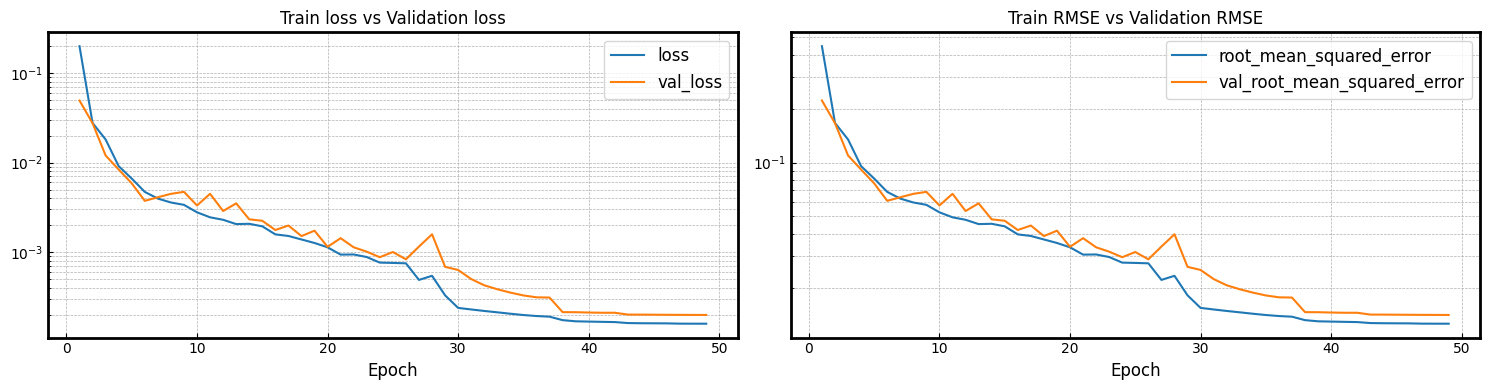

Max. Training MSE: 0.199739158153534
Max. Validation MSE: 0.049404550343752


In [115]:
%matplotlib inline
history_df_freeze = pd.read_csv('')
plotModelHistoryFromFile(history_df_freeze, 
                         fig_initial_value=initial_epoch, 
                         save_fig=False, 
                         file_name='constant2.png'
                         )


## Loading Model and Testing it

In [ ]:
%matplotlib inline
start_time = time.time()

test_model = model

test_model.load_weights('MoviLSTM_freeze_ptrh_sin_2024-10-10_01-21-28/model-00043-0.00015-0.01222.h5') # type: ignore
#test_model.load_weights('MoviLSTM_freeze_ptrh_constant_2024-10-09_21-51-45/model-00050-0.00007-0.00862.h5')



prediction = test_model.predict(sample_test_batch_data) 
print(f'prediction : {prediction.shape}')
print(f'prediction shape[1] -frames : {prediction.shape[1]}')

for i in range(min(5, prediction.shape[1])):
    plt.figure(figsize=(10, 5))

    # Plot the predicted frame
    plt.subplot(1, 2, 1)
    plt.imshow(prediction[0][i], interpolation='antialiased')
    plt.title("Predicted Frame")
    plt.axis('off')  

    # Plot the ground truth frame
    plt.subplot(1, 2, 2)
    plt.imshow(sample_test_batch_labels[0][i], interpolation='antialiased')
    plt.title('Ground Truth')
    plt.axis('off')





    # Print min and max values for analysis
    min_pred_value = prediction[0][i].min()
    max_pred_value = prediction[0][i].max()
    min_gt_value = sample_test_batch_labels[0][i].min()
    max_gt_value = sample_test_batch_labels[0][i].max()

    #print(f"Frame {i+1}:")
    #print(f"  Predicted Frame - Min value: {min_pred_value:.6f}, Max value: {max_pred_value:.6f}")
    #print(f"  Ground Truth    - Min value: {min_gt_value:.6f}, Max value: {max_gt_value:.6f}")
    #print("-" * 50)

    #output_directory = f'{project_folder}/result_constant'
    #if not os.path.exists(output_directory):
    #    os.makedirs(output_directory)    
    #plt.savefig(f'{output_directory}/output{i}', bbox_inches='tight', pad_inches=0, transparent=True)

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

In [33]:
test_model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Figure

In [ ]:
all_hist = []
all_deviation_magnitudes = []

# Compute the deviation magnitudes for all frames and store them
for i in range(min(10, prediction.shape[1])):
    # Calculate the relative error for the current frame
    relative_error = prediction[0][i] - sample_test_batch_labels[0][i]

    # Compute the magnitude of the deviation for each pixel
    deviation_magnitude = np.linalg.norm(relative_error, axis=2)

    # Store the deviation magnitude
    all_deviation_magnitudes.append(deviation_magnitude)

# Convert the list to a numpy array for easier manipulation
all_deviation_magnitudes = np.array(all_deviation_magnitudes)

# Compute the global minimum and maximum deviation magnitudes
global_min = all_deviation_magnitudes.min()
global_max = all_deviation_magnitudes.max()

# Define the bin edges for the histograms
bin_edges = np.linspace(0, 0.15, 51)  # 50 bins from 0 to 1

# List to store normalized deviations
normalized_deviations = [[] for _ in range(len(prediction))]

for i in range(min(10, prediction.shape[1])):
    plt.figure(figsize=(20, 5))  # Adjusted figsize to accommodate the histogram

    # Plot the predicted frame
    plt.subplot(1, 4, 1)
    plt.imshow(prediction[0][i], interpolation='antialiased')
    plt.title("Predicted Frame", fontproperties=font_properties)
    plt.axis('off')  

    # Plot the ground truth frame
    plt.subplot(1, 4, 2)
    plt.imshow(sample_test_batch_labels[0][i], interpolation='antialiased')
    plt.title('Ground Truth', fontproperties=font_properties)
    plt.axis('off')


    #pre_norm = np.linalg.norm(prediction[0][i], axis=2)
    #round_norm = np.linalg.norm(sample_test_batch_labels[0][i], axis=2)
    #relative_error = (pre_norm - ground_norm) / ground_norm

    # Calculate the relative error
    relative_error = (prediction[0][i] - sample_test_batch_labels[0][i]) 

    # Compute the magnitude of the deviation for each pixel
    deviation_magnitude = np.linalg.norm(relative_error, axis=2)

    # Normalize the deviation using global min and max values
    normalized_deviation = (deviation_magnitude - global_min) / (global_max - global_min)

    # Store the normalized deviation
    normalized_deviations[0].append(normalized_deviation)

    # Plot the normalized error for know the deviation distribution
    plt.subplot(1, 4, 3)
    error_img = plt.imshow(normalized_deviation, cmap='viridis', interpolation='antialiased', vmin=0, vmax=0.2)
    plt.title('Normalized Deviation', fontproperties=font_properties)
    plt.colorbar(error_img, shrink=0.8)
    plt.axis('off')

    # Plot the histogram of the normalized deviation using uniform bin edges
    plt.subplot(1, 4, 4)
    plt.hist(normalized_deviation.ravel(), color='blue', alpha=0.7, linewidth=2, bins=bin_edges) # type: ignore
    plt.title('Deviation Histogram', fontproperties=font_properties)
    plt.xlabel('Normalized Deviation', fontproperties=font_properties)
    plt.ylabel('Frequency', fontproperties=font_properties)
    plt.xlim(0, 0.15)  # Ensure x-axis is consistent
    # Make ticks point inward
    plt.tick_params(axis='both', direction='in', length=6, width=2)

    # Accumulate the relative error values
    all_hist.append(normalized_deviation.ravel())

    # Print min and max values for analysis
    min_pred_value = prediction[0][i].min()
    max_pred_value = prediction[0][i].max()
    min_gt_value = sample_test_batch_labels[0][i].min()
    max_gt_value = sample_test_batch_labels[0][i].max()
    min_error_value = relative_error.min()
    max_error_value = relative_error.max()

    print(f"Frame {i+1}:")
    print(f"  Predicted Frame - Min value: {min_pred_value:.6f}, Max value: {max_pred_value:.6f}")
    print(f"  Ground Truth    - Min value: {min_gt_value:.6f}, Max value: {max_gt_value:.6f}")
    print(f"  Relative Error  - Min value: {min_error_value:.6f}, Max value: {max_error_value:.6f}")
    print("-" * 50)

plt.show()

### Saving Figure (material)

In [36]:
# Ensure that matplotlib plots are displayed inline in the notebook
%matplotlib inline
# Define the base output directory
base_output_directory = f'{project_folder}/result_{heatflux_type}'

# Define the specific output directories
output_directories = {
    'predicted': os.path.join(base_output_directory, 'predicted_frames'),
    'ground_truth': os.path.join(base_output_directory, 'ground_truth'),
    'deviation': os.path.join(base_output_directory, 'normalized_deviation')
}

# Ensure the output directories exist
for directory in output_directories.values():
    os.makedirs(directory, exist_ok=True)

def save_figure(data, output_path, cmap='viridis', vmin=0, vmax=0.2, dpi=600):
    plt.figure(figsize=(5, 5))
    plt.imshow(data, interpolation='antialiased', cmap=cmap, vmin=vmin, vmax=vmax)
    plt.axis('off')
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0, transparent=True, dpi=dpi)
    plt.close()

for i in range(min(10, prediction.shape[1])):
    figures = [
        (prediction[0][i], os.path.join(output_directories["predicted"], f'predicted_frame_{i}.png')),
        (sample_test_batch_labels[0][i], os.path.join(output_directories["ground_truth"], f'ground_truth_{i}.png')),
        (normalized_deviations[0][i], os.path.join(output_directories["deviation"], f'normalized_deviation_{i}.png'))
    ]

    for data, output_path in figures:
        save_figure(data, output_path)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


### Building effect figure and saving it

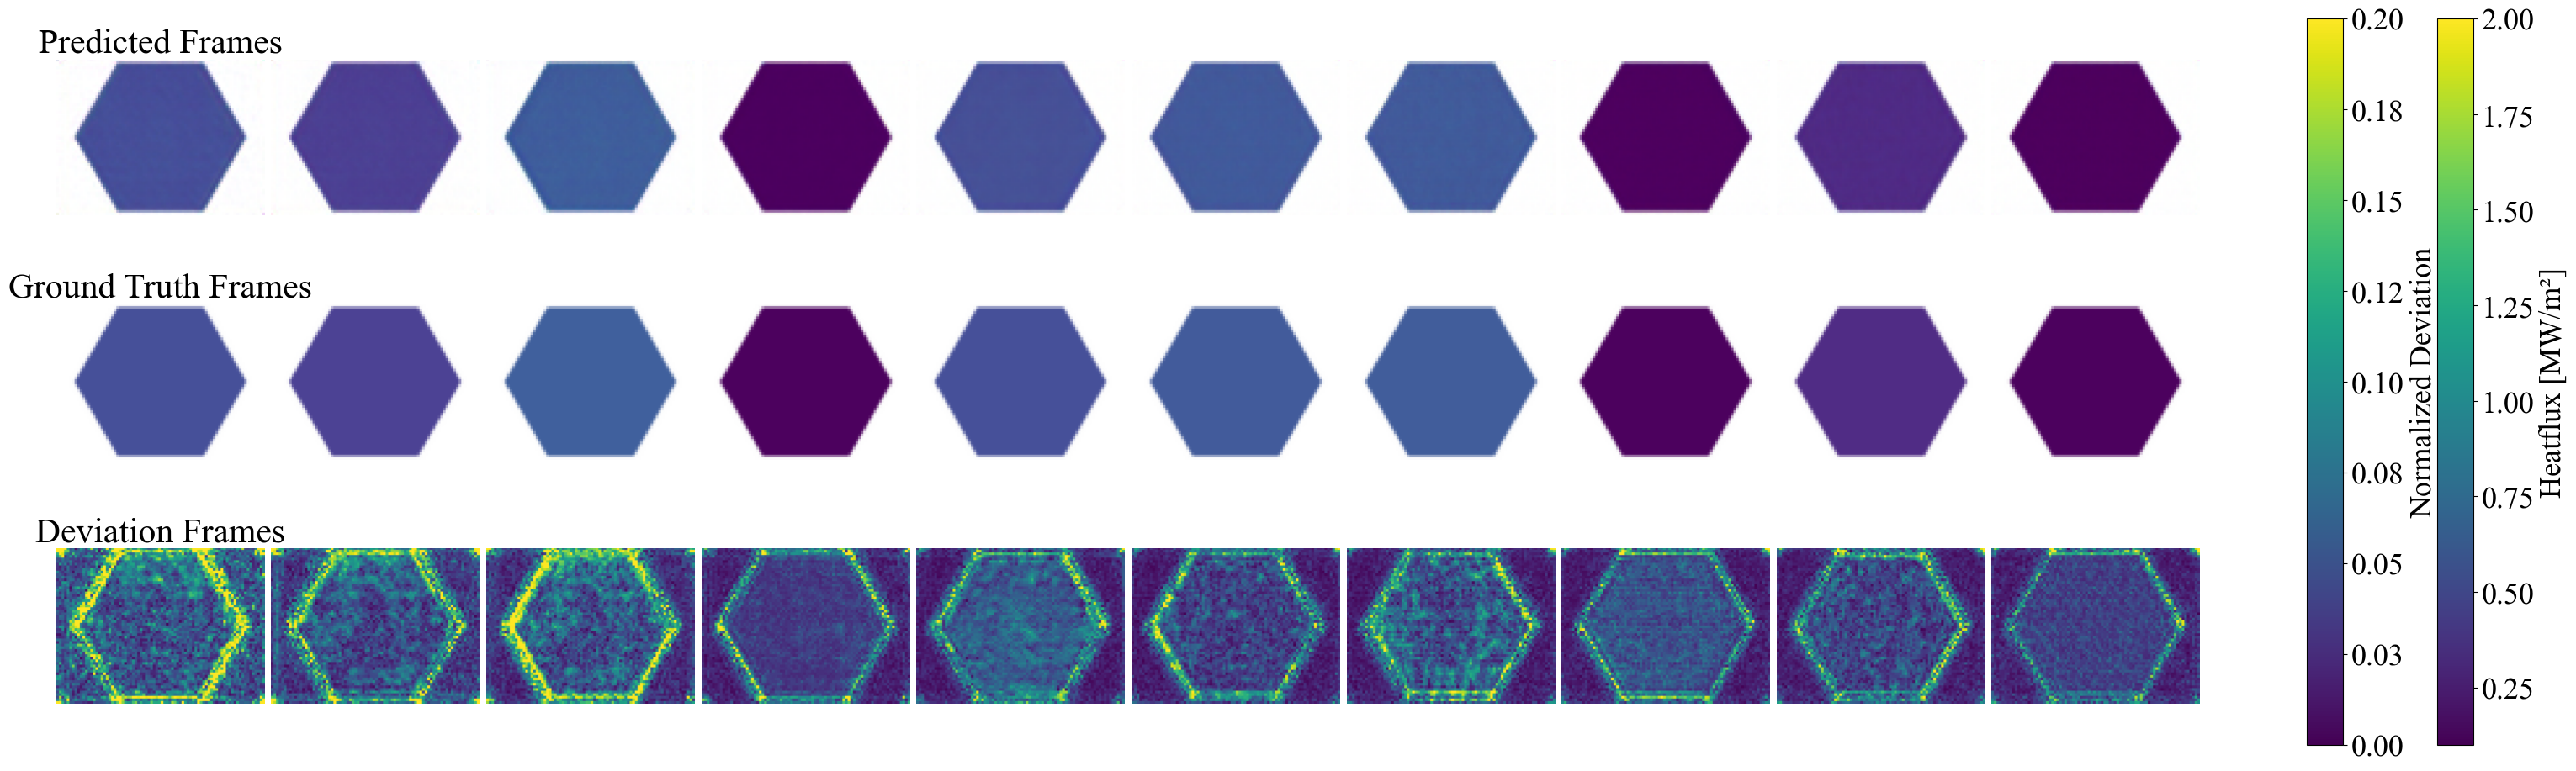

In [51]:
# Define the global font size parameter
FONT_SIZE = 26
TICK_LABEL_SIZE = 26  # Define a global parameter for tick label size

# Configure Matplotlib to use LaTeX
#plt.rcParams['text.usetex'] = True
#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.serif'] = ['Times New Roman']
#plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{mathptmx}'


# Define the specific output directories
output_directories = {
    'predicted': os.path.join(base_output_directory, 'predicted_frames'),
    'ground_truth': os.path.join(base_output_directory, 'ground_truth'),
    'deviation': os.path.join(base_output_directory, 'normalized_deviation')
}

# Load the images
predicted_images = [mpimg.imread(os.path.join(output_directories['predicted'], f'predicted_frame_{i}.png')) for i in range(10)]
ground_truth_images = [mpimg.imread(os.path.join(output_directories['ground_truth'], f'ground_truth_{i}.png')) for i in range(10)]
deviation_images = [mpimg.imread(os.path.join(output_directories['deviation'], f'normalized_deviation_{i}.png')) for i in range(10)]

# Define the figure and axis with adjusted spacing
fig, axes = plt.subplots(3, 10, figsize=(30, 10), constrained_layout=True, gridspec_kw={'hspace': 0, 'wspace': 0})

# Display images on the respective axes
for i in range(10):
    axes[0, i].imshow(predicted_images[i])
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Predicted Frames', fontproperties=font_properties, fontsize=30)

    axes[1, i].imshow(ground_truth_images[i])
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Ground Truth Frames', fontproperties=font_properties, fontsize=30)

    axes[2, i].imshow(deviation_images[i])
    axes[2, i].axis('off')
    if i == 0:
        axes[2, i].set_title('Deviation Frames', fontproperties=font_properties, fontsize=30)


cmap = plt.cm.viridis # type: ignore  # Change colormap here if needed 

# Add the first colorbar on the right
cbar1 = fig.colorbar(
    plt.cm.ScalarMappable(norm=Normalize(vmin=0.1, vmax=2), cmap=cmap), # type: ignore
    ax=axes, 
    location='right', 
    fraction=0.02, 
    pad=0.0
    )
cbar1.set_label('Heatflux [MW/m²]', labelpad=None, fontsize=FONT_SIZE, fontproperties=font_properties)


# Set font properties for tick labels
for label in cbar1.ax.get_yticklabels():
    label.set_fontproperties(font_properties)

# Add the second colorbar on the right, below the first one
cbar2 = fig.colorbar(
    plt.cm.ScalarMappable(norm=Normalize(vmin=0.0, vmax=0.2), cmap=cmap), # type: ignore
    ax=axes, 
    location='right', 
    fraction=0.02, 
    pad=0.05
    )
cbar2.set_label('Normalized Deviation', labelpad=None, fontsize=FONT_SIZE, fontproperties=font_properties)


# Set font properties for tick labels
for label in cbar2.ax.get_yticklabels():
    label.set_fontproperties(font_properties)

cbar2.ax.tick_params(labelsize=TICK_LABEL_SIZE)  # Set tick label size
cbar1.ax.tick_params(labelsize=TICK_LABEL_SIZE)  # Set tick label size
# Format the tick labels to two decimal places
cbar2.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2f}'))

# Adjust layout and display the figure
output_figure_path = os.path.join(base_output_directory, f'combined_figure_{heatflux_type}.png')
#plt.savefig(output_figure_path, bbox_inches='tight', pad_inches=0.1, dpi=600)
plt.show()

Main

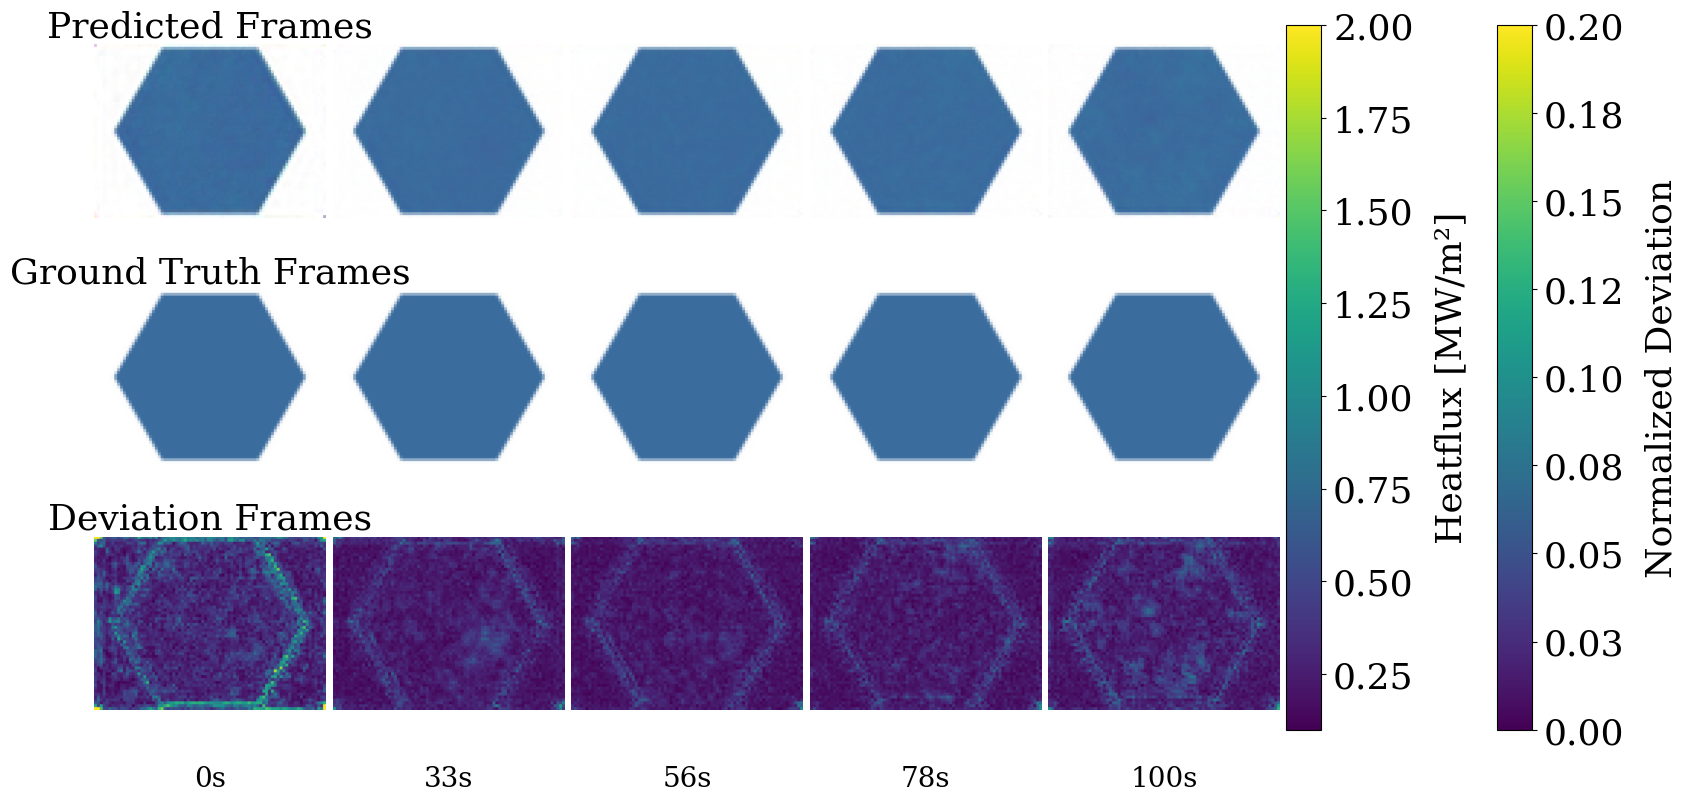

In [110]:

# Define global font size parameters
FONT_SIZE = 26  # Consistent font size
TICK_LABEL_SIZE = FONT_SIZE  # Consistent tick label size

# Extract time points from the tensor
imgs_tensor = getImgTensor(10)  # Get tensor data
time_points = imgs_tensor[0]  # Extract the time points array

# Selected indices and automatic time label generation
selected_indices = [0, 3, 5, 7, 9]  # 5 frames
time_labels = [f'{time_points[i]}s' for i in selected_indices]

# Define the specific output directories
output_directories = {
    'predicted': os.path.join(base_output_directory, 'predicted_frames'),
    'ground_truth': os.path.join(base_output_directory, 'ground_truth'),
    'deviation': os.path.join(base_output_directory, 'normalized_deviation')
}

# Load images for the selected indices
predicted_images = [mpimg.imread(os.path.join(output_directories['predicted'], f'predicted_frame_{i}.png')) for i in selected_indices]
ground_truth_images = [mpimg.imread(os.path.join(output_directories['ground_truth'], f'ground_truth_{i}.png')) for i in selected_indices]
deviation_images = [mpimg.imread(os.path.join(output_directories['deviation'], f'normalized_deviation_{i}.png')) for i in selected_indices]

# Adjust the figure and GridSpec layout with more spacing between colorbars
fig = plt.figure(figsize=(20, 10))  # Adjusted size for layout
gs = GridSpec(4, 11, 
              width_ratios=[1, 1, 1, 1, 1, 0.15, 0.7, 0.15, 0.2, 0.1, 0.1], 
              height_ratios=[1, 1, 1, 0.15], 
              wspace=0.05
              )

# Display the images in the layout
for idx, i in enumerate(selected_indices):
    ax = fig.add_subplot(gs[0, idx])
    ax.imshow(predicted_images[idx])
    ax.axis('off')
    if idx == 0:
        ax.set_title('Predicted Frames', fontsize=FONT_SIZE)

    ax = fig.add_subplot(gs[1, idx])
    ax.imshow(ground_truth_images[idx])
    ax.axis('off')
    if idx == 0:
        ax.set_title('Ground Truth Frames', fontsize=FONT_SIZE)

    ax = fig.add_subplot(gs[2, idx])
    ax.imshow(deviation_images[idx])
    ax.axis('off')
    if idx == 0:
        ax.set_title('Deviation Frames', fontsize=FONT_SIZE)

# Add time labels at the bottom
for idx, label in enumerate(time_labels):
    ax = fig.add_subplot(gs[3, idx])
    ax.text(0.5, 0.5, label, fontsize=FONT_SIZE - 6, ha='center', va='center', transform=ax.transAxes)
    ax.axis('off')  # Hide axes since only labels are shown

# Add the first colorbar (Heatflux)
cax1 = fig.add_subplot(gs[:3, 5])  # First colorbar
cbar1 = fig.colorbar(
    plt.cm.ScalarMappable(norm=Normalize(vmin=0.1, vmax=2), cmap=plt.cm.viridis),
    cax=cax1
)
cbar1.set_label('Heatflux [MW/m²]', fontsize=FONT_SIZE, labelpad=15)  # Increased label padding
cbar1.ax.tick_params(labelsize=TICK_LABEL_SIZE, pad=5)

# Add the second colorbar (Normalized Deviation) with more separation
cax2 = fig.add_subplot(gs[:3, 7])  # Second colorbar with adjusted placement
cbar2 = fig.colorbar(
    plt.cm.ScalarMappable(norm=Normalize(vmin=0.0, vmax=0.2), cmap=plt.cm.viridis),
    cax=cax2
)
cbar2.set_label('Normalized Deviation', fontsize=FONT_SIZE, labelpad=15)  # Increased label padding
cbar2.ax.tick_params(labelsize=TICK_LABEL_SIZE, pad=5)
cbar2.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2f}'))

# Save and display the figure
output_figure_path = os.path.join(base_output_directory, f'combined_figure_{heatflux_type}_main.png')
plt.savefig(output_figure_path, bbox_inches='tight', pad_inches=0.1, dpi=1000)
plt.show()


## Deviation Accumlation

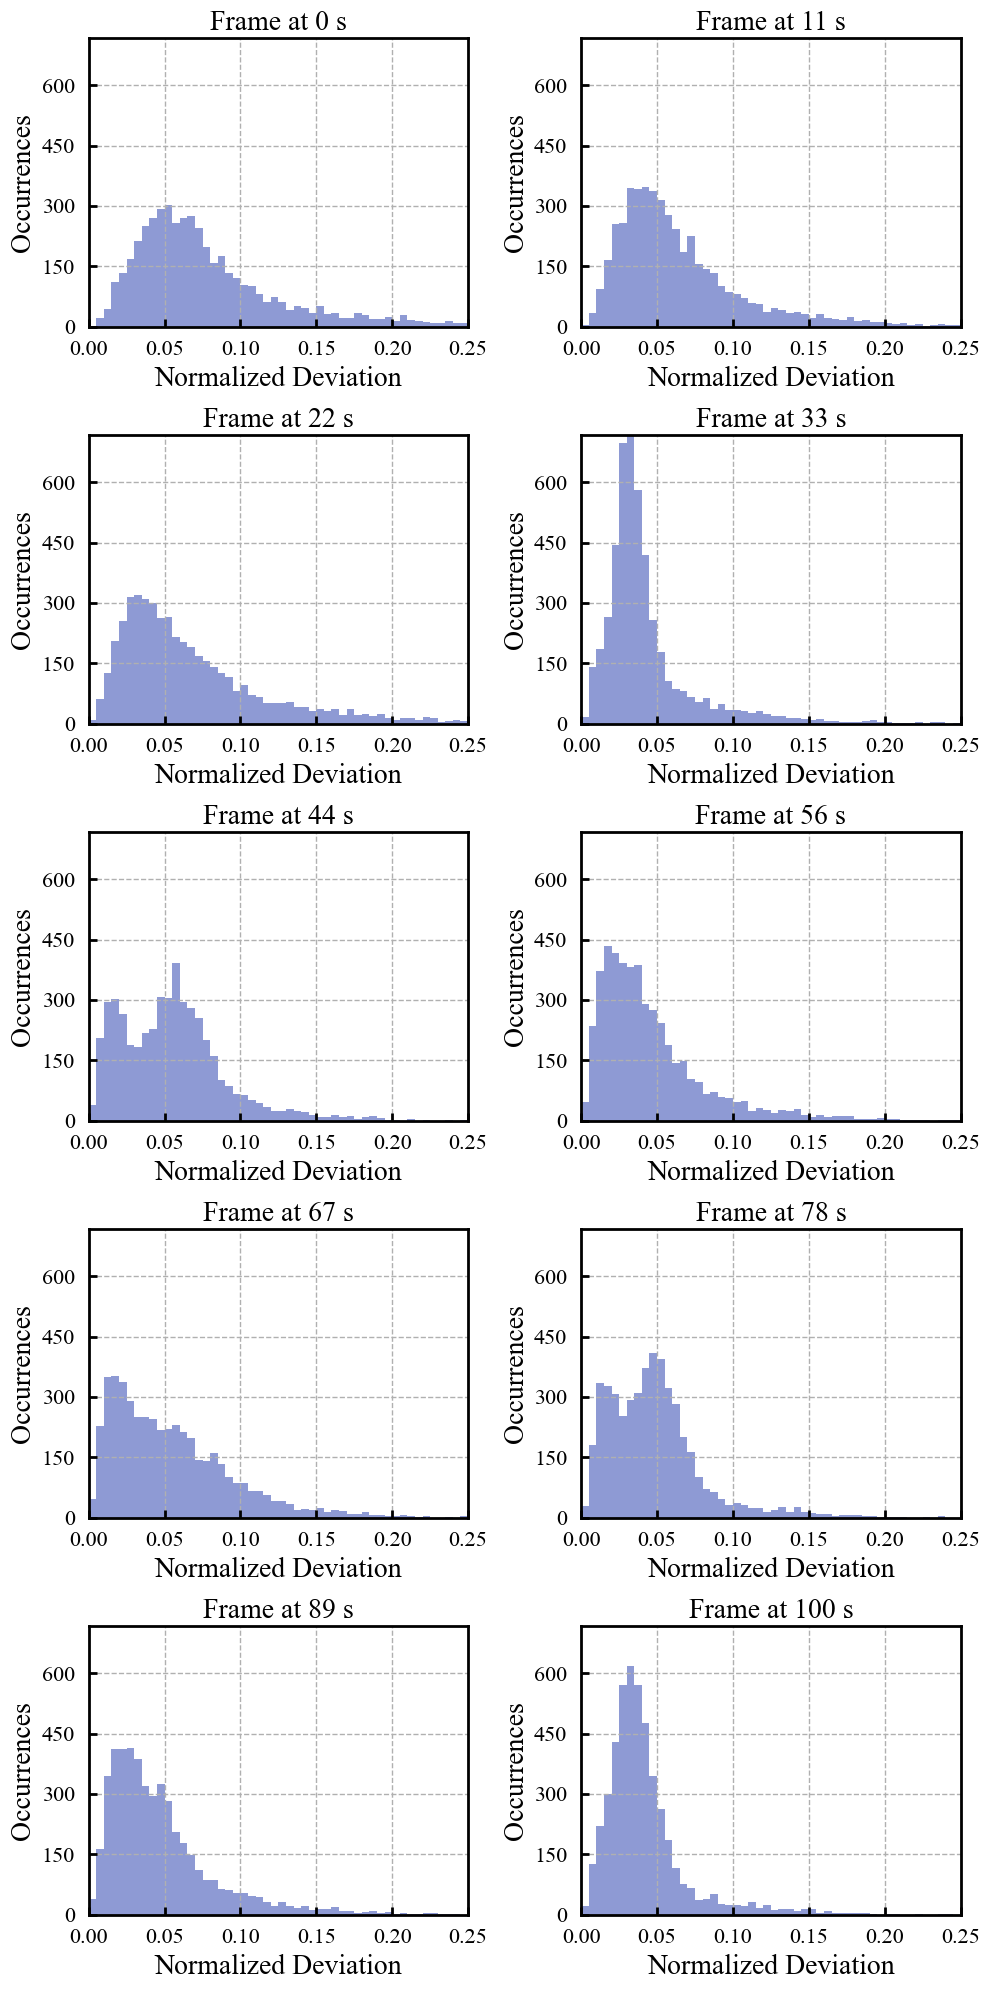

In [38]:
# Assuming all_hist is already populated with the normalized deviation values
# all_hist = [normalized_deviation.ravel() for each frame]
# Define the number of histograms

TICK_LABEL_SIZE = 16  # Increased tick label size

num_histograms = len(all_hist)

# Create a figure with subplots arranged in a grid
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Define global variable for font properties with font size
font_properties = FontProperties(fname='/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf') # type: ignore


# Define the bin edges for the histograms
bin_edges = np.linspace(0, 0.25, 51)  

# Calculate the global maximum y-value across all histograms
global_max_y = max(np.histogram(hist, bins=bin_edges)[0].max() for hist in all_hist)

# Function to format x-axis tick labels to 2 decimal places
def format_func(value, tick_number):
    return f'{value:.2f}'

# Plot each histogram in its respective subplot //red #bd71c1 , blue #5e70c2
for i in range(num_histograms):
    axes[i].hist(all_hist[i], bins=bin_edges, color='#5e70c2', alpha=0.7, linewidth=2, zorder=1)
    axes[i].set_title(f'Frame at {imgs_tensor[0][i]} s', fontproperties=font_properties, fontsize=20) # imgs_tensor[0] is the time step
    axes[i].set_xlabel('Normalized Deviation', fontproperties=font_properties, fontsize=20)
    axes[i].set_ylabel('Occurrences', fontproperties=font_properties, fontsize=20)
    axes[i].tick_params(axis='both', labelsize=TICK_LABEL_SIZE, direction='in', length=6, width=2, pad=10)
    axes[i].set_xlim(0, 0.25)  # Ensure x-axis is consistent
    axes[i].set_ylim(0, global_max_y)  # Set y-axis limits to be uniform

    # Set the linewidth of the x and y axes
    axes[i].spines['top'].set_linewidth(2)
    axes[i].spines['bottom'].set_linewidth(2)
    axes[i].spines['left'].set_linewidth(2)
    axes[i].spines['right'].set_linewidth(2)

    # Add grid lines as dashed lines on top of the bars
    axes[i].grid(True, linestyle='--', linewidth=1, zorder=2)

    # Set appropriate number of ticks on x and y axes
    axes[i].xaxis.set_major_locator(MaxNLocator(nbins=5))
    axes[i].yaxis.set_major_locator(MaxNLocator(nbins=6))

    # Format x-axis tick labels to 2 decimal places
    axes[i].xaxis.set_major_formatter(FuncFormatter(format_func))

    # Set font properties for tick labels
    for label in axes[i].get_xticklabels() + axes[i].get_yticklabels():
        label.set_fontproperties(font_properties)
        label.set_fontsize(TICK_LABEL_SIZE)  # Set the font size for tick labels

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig(os.path.join(base_output_directory, f'histograms_{heatflux_type}.png'), 
            dpi=600, 
            bbox_inches='tight'
            )
# Show the combined figure
plt.show()

### Save it

In [60]:
plt.savefig(os.path.join(base_output_directory, f'histograms_{heatflux_type}.png'), 
            dpi=600, 
            bbox_inches='tight'
            )

<Figure size 640x480 with 0 Axes>

## test specific case and show batch_data and batch_label

In [40]:
# based on the target values, find the closest filenames

# if from the whole dataset
#data_csv = pd.read_csv(project_folder + dataset_name + '/dataset_info.csv') 

# Split the folder_name into number and value, and extract value as float
#data_csv['value'] = data_csv['folder_name'].apply(lambda x: float(x.split('_')[1]))

# from the test dataset
# Split the folder_name into number and value, and extract value as float
test_df['value'] = test_df['folder_name'].apply(lambda x: float(x.split('_')[1]))

# Target values
#target_values = [7e5, 4e5, 2.75e5, 1.89e5, 1.45e5, 
#                 1.30E+06, 7.40E+05, 4.75E+05, 3.68E+05, 2.89E+05]

target_values = np.linspace(1e5, 1e6, 3)
# Initialize a list to hold the closest filenames
closest_filenames = []

# Loop through the target values only once to compute the differences
for target_value in target_values:
    test_df['diff'] = abs(test_df['value'] - target_value)
    closest_filename = test_df.loc[test_df['diff'].idxmin(), 'folder_name']
    closest_filenames.append(closest_filename)
    print(closest_filename)
    
groundtruth_heatflux = [float(re.search(r'_(\d+\.\d+)$', item).group(1)) for item in closest_filenames] # type: ignore
#print(groundtruth_heatflux)

closest_filename_index = 2
specific_folder_name = closest_filenames[closest_filename_index]
#print(specific_folder_name)


specific_input_folder_path = project_folder + dataset_name + '/input/' + specific_folder_name
#print(specific_input_folder_path)
specific_output_folder_path = project_folder + dataset_name + '/output/' + specific_folder_name
#print(specific_output_folder_path)

# now, these paths contain only one folder
input_folders_list = [specific_input_folder_path]
#print(input_folders_list)
output_folders_list = [specific_output_folder_path]
#print(input_folders_list)

# use generator function to get the specific batch data
specific_generator = generator(dataset_source_path, input_folders_list, output_folders_list, test_batch_size, imgs_tensor)

specific_batch_data, specific_batch_labels = next(specific_generator)

#print(specific_batch_data.shape)

#print(prediction.shape)



413A_152460.0213
253A_528825.729
464A_993106.8491
Source path =  /home/linux/IHCPs/dataset_ptrh_sin ; batch size = 1


/tmp/ipykernel_52061/4213139644.py:117: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(input_img_path).astype(np.float32)
/tmp/ipykernel_52061/4213139644.py:118: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label_img = imread(label_img_path).astype(np.float32)


In [ ]:
# show data
for i in range(min(3, prediction.shape[1])): # shape[1] = frame
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(specific_batch_data[0][i], interpolation='antialiased')
    plt.title("specific_batch_data")

    plt.subplot(1, 2, 2)
    plt.imshow(specific_batch_labels[0][i], interpolation='antialiased')
    plt.title('specific_batch_labels')
    plt.axis('off')

## Heatflux Value Comparision

now input color, output heatflux

In [41]:
prediction = test_model.predict(specific_batch_data)

# Initialize lists to hold results
x_frames = []
cal_prediction_heatflux_values = []
groundtruth_heatflux_values = []
error_values= []
me_p_values = []  # List to collect me_p values


A = groundtruth_heatflux[closest_filename_index]
#print(f'the value of A is {A}')
#true_value_test =A * np.sin(((np.pi * 30) / 30) - np.pi / 2) + A
#print(f'true value is {true_value_test}')
time_points = getImgTensor(n_frames)[0]
#print(A)
#print(f'the value of t is {time_points}')
#print(len(time_points))

for frame_index in range(prediction.shape[1]):
    #value1 = find_and_plot_closest_scalar(prediction, viridis_unique, frame_index=frame_index, show_image=False)
    #value2 = find_and_plot_closest_scalar(specific_batch_labels, viridis_unique, frame_index=frame_index, show_image=False)
    #error_value = (value1 - value2) / value2

    # Calculate the errors for the current frame based on the color deviation
    mse, mae, me_p = calculate_errors_single_frame(prediction, 
                                                   specific_batch_labels, 
                                                   batch_index=0, 
                                                   frame_index=frame_index
                                                   ) # type: ignore

    print("MSE:", mse)
    print("MAE:", mae)
    print("ME_p:", me_p)



    #  true value
    time_point = time_points[frame_index]

    #true_value = groundtruth_heatflux[closest_filename_index]
    true_value = cal_true_value(heatflux_type=heatflux_type, 
                                A=A, 
                                time_point=time_point, 
                                groundtruth_heatflux=groundtruth_heatflux, 
                                closest_filename_index=closest_filename_index
                                )

    print(f'true value is {true_value}')

    delta_value = me_p * true_value
    print(f'delta value is {delta_value}')

    cal_prediction_heatflux = delta_value + true_value
    print(f'cal_prediction_heatflux is {cal_prediction_heatflux}')

    # Store the results for plotting
    x_frames.append(frame_index)
    cal_prediction_heatflux_values.append(cal_prediction_heatflux)
    groundtruth_heatflux_values.append(true_value)
    #error_values.append(error_value)
       
    # Collect the me_p value
    me_p_values.append(me_p)


    #print(f'the error is {error_value}')
    print(f'groundtruth_heatflux is {groundtruth_heatflux[closest_filename_index]}')
    print(f'cal_prediction_heatflux is {cal_prediction_heatflux}')

    print("MSE:", mse)
    print("MAE:", mae)
    print("Mean Error (ME):", me_p * 100)



1/1 [==============================] - 0s 109ms/step
MSE: 0.0002414234970350025
MAE: 0.010871654
ME_p: -0.0007669329643249512
true value is 551.6749434265075
delta value is -0.4230976997058912
cal_prediction_heatflux is 551.2518457268017
groundtruth_heatflux is 993106.8491
cal_prediction_heatflux is 551.2518457268017
MSE: 0.0002414234970350025
MAE: 0.010871654
Mean Error (ME): -0.07669329643249512
MSE: 0.00038309664340208186
MAE: 0.014570567
ME_p: -0.005172312259674072
true value is 619634.2978742818
delta value is -3204.9420754096836
cal_prediction_heatflux is 616429.3557988721
groundtruth_heatflux is 993106.8491
cal_prediction_heatflux is 616429.3557988721
MSE: 0.00038309664340208186
MAE: 0.014570567
Mean Error (ME): -0.5172312259674072
MSE: 0.0006964782899831583
MAE: 0.019056715
ME_p: 0.006238341331481934
true value is 1681852.0797235663
delta value is 10491.967342378372
cal_prediction_heatflux is 1692344.0470659446
groundtruth_heatflux is 993106.8491
cal_prediction_heatflux is 1692

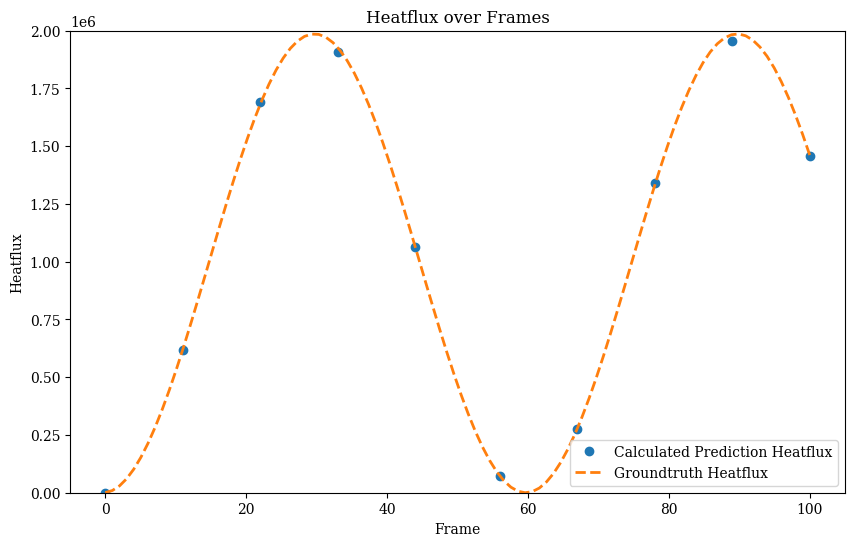

In [42]:
%matplotlib inline
# Plot the results
plt.figure(figsize=(10, 6))

# Plot the calculated prediction heatflux with markers
plt.plot(time_points, cal_prediction_heatflux_values, 
         label='Calculated Prediction Heatflux', 
         marker='o', 
         linestyle='None', 
         linewidth=2
         )

x_groundtruth = np.linspace(0, 100, 100)

# Plot the groundtruth heatflux as a smooth curve
Y_validation = [cal_true_value(heatflux_type=heatflux_type, 
                                A=A, 
                                time_point=tp, 
                                groundtruth_heatflux=groundtruth_heatflux, 
                                closest_filename_index=closest_filename_index
                                ) for tp in x_groundtruth
                ]

plt.plot(x_groundtruth, 
         Y_validation, 
         label='Groundtruth Heatflux', 
         linestyle='--', 
         linewidth=2)

plt.xlabel('Frame')
plt.ylabel('Heatflux')
plt.title('Heatflux over Frames')
plt.legend(loc='lower right')  # Adjusted the legend location to lower right

# Set the y-axis limits
plt.ylim(0, 2e6)  # Adjust the y-axis limits as needed

plt.show()

### Output Data

In [110]:
# Ensure time_points and cal_prediction_heatflux_values have the same length
# If they do, you can create the DataFrame directly
df_prediction = pd.DataFrame({
    'Prediction Frame': time_points,
    f'Prediction {closest_filename_index+1}': cal_prediction_heatflux_values
})

# Create the DataFrame for groundtruth
df_groundtruth = pd.DataFrame({
    'Groundtruth Frame': x_groundtruth,
   f'Groundtruth {closest_filename_index+1}': Y_validation
})

# Combine the two DataFrames
df_combined = pd.concat([df_prediction, df_groundtruth], axis=1)

# Export the DataFrame to a CSV file
df_combined.to_csv(f'./result_{heatflux_type}/heatflux_data_{heatflux_type}_{closest_filename_index+1}.csv', 
                   index=False
                   )


## Statistical Distribution of Accuracy

In [53]:
# Initialize lists to hold results
x_frames = []
cal_prediction_heatflux_values = []
groundtruth_heatflux_values = []
error_values = []
me_p_values = []  # List to collect me_p values

# Define target values for closest_filename_index
target_values = np.linspace(1e5, 1e6, 5)


for closest_filename_index in range(len(target_values)):

    A = groundtruth_heatflux[closest_filename_index]

    time_points = getImgTensor(n_frames)[0]

    test_df['value'] = test_df['folder_name'].apply(lambda x: float(x.split('_')[1]))

    closest_filenames = []

    # Loop through the target values only once to compute the differences
    for target_value in target_values:
        test_df['diff'] = abs(test_df['value'] - target_value)
        closest_filename = test_df.loc[test_df['diff'].idxmin(), 'folder_name']
        closest_filenames.append(closest_filename)
        #print(closest_filename)
        
    groundtruth_heatflux = [float(re.search(r'_(\d+\.\d+)$', item).group(1)) for item in closest_filenames] # type: ignore
    #print(groundtruth_heatflux)

    specific_folder_name = closest_filenames[closest_filename_index]
    #print(specific_folder_name)

    specific_input_folder_path = project_folder + dataset_name + '/input/' + specific_folder_name
    #print(specific_input_folder_path)
    specific_output_folder_path = project_folder + dataset_name + '/output/' + specific_folder_name
    #print(specific_output_folder_path)

    # now, these paths contain only one folder
    input_folders_list = [specific_input_folder_path]
    #print(input_folders_list)
    output_folders_list = [specific_output_folder_path]
    #print(input_folders_list)

    # use generator function to get the specific batch data
    specific_generator = generator(dataset_source_path, input_folders_list, output_folders_list, test_batch_size, imgs_tensor)

    specific_batch_data, specific_batch_labels = next(specific_generator)

    prediction = test_model.predict(specific_batch_data)
    

    for frame_index in range(prediction.shape[1]):
        # Calculate the errors for the current frame based on the color deviation
        mse, mae, me_p = calculate_errors_single_frame(prediction, 
                                                    specific_batch_labels, 
                                                    batch_index=0, 
                                                    frame_index=frame_index
                                                    ) # type: ignore
        
        # Collect the me_p value
        me_p_values.append(me_p)




# Create a DataFrame from the collected me_p values
me_p_df = pd.DataFrame(np.abs(me_p_values), columns=[f'{heatflux_type}'])

# Define the file path to save the DataFrame
output_directory = f'result_{heatflux_type}/accuracy_distribution'
os.makedirs(output_directory, exist_ok=True)
output_file_path = os.path.join(output_directory, f'{heatflux_type}_accuracy.csv')

me_p_df.to_csv(output_file_path, 
               index=False
               )

Source path =  /home/linux/IHCPs/dataset_ptrh_constant ; batch size = 1


/tmp/ipykernel_52061/4213139644.py:117: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(input_img_path).astype(np.float32)
/tmp/ipykernel_52061/4213139644.py:118: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label_img = imread(label_img_path).astype(np.float32)


1/1 [==============================] - 0s 133ms/step
Source path =  /home/linux/IHCPs/dataset_ptrh_constant ; batch size = 1


/tmp/ipykernel_52061/4213139644.py:117: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(input_img_path).astype(np.float32)
/tmp/ipykernel_52061/4213139644.py:118: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label_img = imread(label_img_path).astype(np.float32)


1/1 [==============================] - 0s 108ms/step
Source path =  /home/linux/IHCPs/dataset_ptrh_constant ; batch size = 1


/tmp/ipykernel_52061/4213139644.py:117: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(input_img_path).astype(np.float32)
/tmp/ipykernel_52061/4213139644.py:118: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label_img = imread(label_img_path).astype(np.float32)


1/1 [==============================] - 0s 108ms/step
Source path =  /home/linux/IHCPs/dataset_ptrh_constant ; batch size = 1


/tmp/ipykernel_52061/4213139644.py:117: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(input_img_path).astype(np.float32)
/tmp/ipykernel_52061/4213139644.py:118: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label_img = imread(label_img_path).astype(np.float32)


1/1 [==============================] - 0s 112ms/step
Source path =  /home/linux/IHCPs/dataset_ptrh_constant ; batch size = 1


/tmp/ipykernel_52061/4213139644.py:117: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(input_img_path).astype(np.float32)
/tmp/ipykernel_52061/4213139644.py:118: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label_img = imread(label_img_path).astype(np.float32)


1/1 [==============================] - 0s 110ms/step


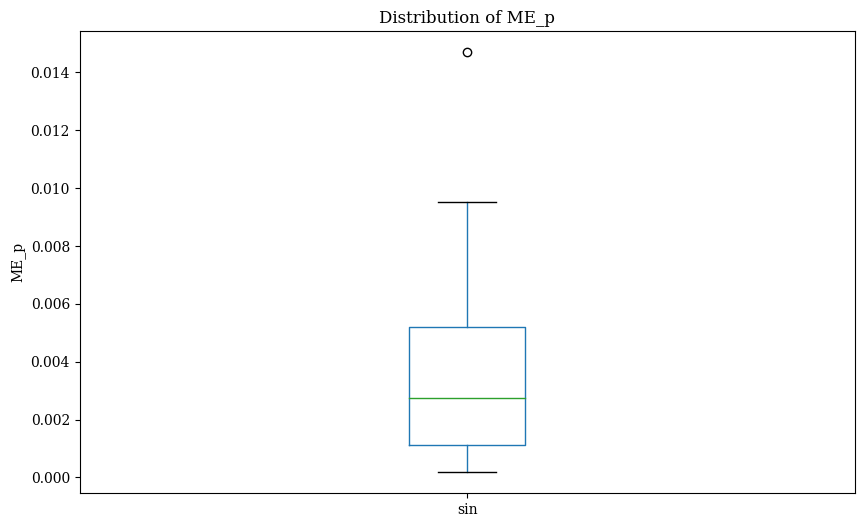

In [49]:
# Plot the box plot
plt.figure(figsize=(10, 6))
me_p_df.boxplot(column=f'{heatflux_type}', grid=False)
plt.title('Distribution of ME_p')
plt.ylabel('ME_p')
plt.show()

## Efficiency

In [36]:


# Run the prediction multiple times and record execution times
execution_times = []
for _ in range(50):
    start_time = time.time()
    prediction = test_model.predict(sample_test_batch_data)
    end_time = time.time()
    execution_times.append(end_time - start_time)

# Calculate mean and standard deviation
mean_time = np.mean(execution_times)
std_dev_time = np.std(execution_times)

# Create a dataframe to store the results
df = pd.DataFrame({
    'Execution Time (s)': execution_times,
    'Mean Time (s)': [mean_time]*50,
    'Standard Deviation (s)': [std_dev_time]*50
})

# Save the dataframe to a file
file_path = f'result_{heatflux_type}/efficiency_test/{heatflux_type}_execution_times.csv'

# Create the directory if it does not exist
os.makedirs(os.path.dirname(file_path), exist_ok=True)


df.to_csv(file_path, index=False)



1/1 [==============================] - 0s 87ms/step


In [ ]:
importlib.reload(MoviLSTMnet_toolkit)

# plot
# Read the CSV files into DataFrames
constant_df = pd.read_csv('result_constant/efficiency_test/constant_execution_times.csv')
sin_df = pd.read_csv('result_sin/efficiency_test/sin_execution_times.csv')

constant_df['Type'] = 'Constant'
sin_df['Type'] = 'Sin'

# Combine the DataFrames
combined_df = pd.concat([constant_df, sin_df])

# Create the box plot
plt.figure(figsize=(10, 6))
boxplot = combined_df.boxplot(column='Execution Time (s)', 
                              by='Type', 
                              grid=False, 
                              showfliers=True
                              )

# Apply the 1.5 IQR rule to identify outliers
for dataset in ['Constant', 'Sin']:
    data = combined_df[combined_df['Type'] == dataset]['Execution Time (s)']
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    print(f"Outliers in {dataset} dataset:")
    print(outliers)

plt.suptitle('Execution Time Comparison: Constant vs Sin')
plt.title('')  # Remove the automatic title that pandas adds
plt.ylabel('Execution Time (s)')



plt.show()
